<a href="https://www.kaggle.com/code/mohammad007kh/chest-x-ray-pneumonia-classifier-resnet50?scriptVersionId=233177363" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# A Pneumonia Detection system using ResNet50 + Transfer Learning on chest X-ray images.
ResNet50 was used (without top layer) as a feature extractor and applied data augmentation to avoid overfitting.

### Imports

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

### Paths to Dataset

In [4]:
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

### Check Class Distribution (for class weights)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


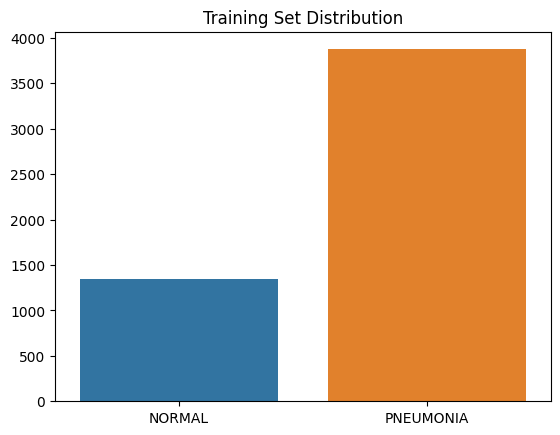

Class weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


In [6]:
def count_images(directory):
    return {
        'NORMAL': len(os.listdir(os.path.join(directory, 'NORMAL'))),
        'PNEUMONIA': len(os.listdir(os.path.join(directory, 'PNEUMONIA')))
    }

train_counts = count_images(train_dir)

# Visualize class distribution
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title("Training Set Distribution")
plt.show()

# Compute class weights
labels = [0]*train_counts['NORMAL'] + [1]*train_counts['PNEUMONIA']
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

### Data Generators with Augmentation

In [7]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Load Pretrained ResNet50 Model

In [8]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Train the Model with Class Weights

In [9]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=class_weights
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 541ms/step - accuracy: 0.5029 - loss: 0.7121 - val_accuracy: 0.7500 - val_loss: 0.6765
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 506ms/step - accuracy: 0.5974 - loss: 0.6680 - val_accuracy: 0.6250 - val_loss: 0.6601
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 518ms/step - accuracy: 0.7054 - loss: 0.6384 - val_accuracy: 0.6250 - val_loss: 0.6405
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 514ms/step - accuracy: 0.7684 - loss: 0.6177 - val_accuracy: 0.6250 - val_loss: 0.6273
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 537ms/step - accuracy: 0.7982 - loss: 0.5874 - val_accuracy: 0.5625 - val_loss: 0.6201
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 505ms/step - accuracy: 0.7922 - loss: 0.5708 - val_accuracy: 0.6250 - val_loss: 0.5955
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 503ms/step - accuracy: 0.7940 - loss: 0.5539 - val_accuracy: 0.7500 - val_loss: 0.5806
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 503ms/step - accuracy: 0.8032 - loss: 0.5247 - va

### Let's save the model before we do anything else.

In [10]:
model.save('pneumonia_model.h5')

### Plot Accuracy & Loss curves

In [11]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1,2,2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.legend()
    plt.title("Loss")

    plt.show()

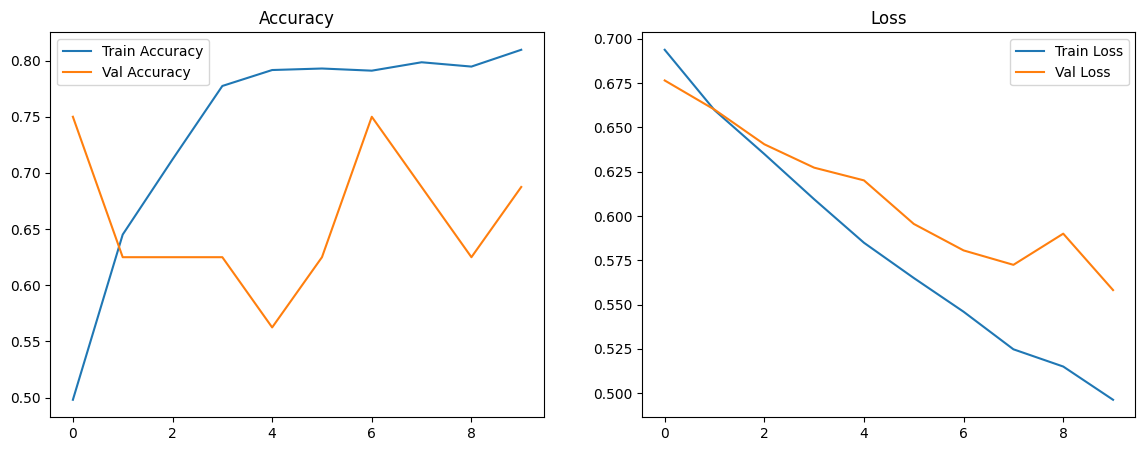

In [12]:
plot_history(history)

### Evaluation on Test set

In [13]:
def EvaluateOnTestSet():
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"\nTest Accuracy: {test_acc:.2f} - Loss: {test_loss:.2f}")

In [14]:
EvaluateOnTestSet()

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - accuracy: 0.7988 - loss: 0.5104

Test Accuracy: 0.78 - Loss: 0.56


### Classification Report and confusion matrix 

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 346ms/step

Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.67      0.83      0.74       234
   PNEUMONIA       0.88      0.75      0.81       390

    accuracy                           0.78       624
   macro avg       0.77      0.79      0.78       624
weighted avg       0.80      0.78      0.78       624



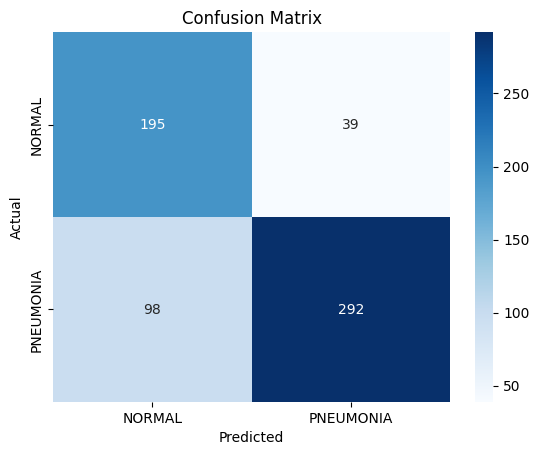

In [15]:
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_labels = (y_pred > 0.5).astype(int).flatten()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_labels, target_names=["NORMAL", "PNEUMONIA"]))

cm = confusion_matrix(y_true, y_pred_labels)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Well, ~79% is a strong precision/recall. But let's try to make it even better.

## Fine-Tune ResNet50 (Low LR)
By this part of the notebook, we've only used ResNet50 as a frozen feature extractor. Let's try to make it fully adapt to the dataset.

In [16]:
#If the model was saved, we could continue from that.
from tensorflow.keras.models import load_model
model = load_model('pneumonia_model.h5')

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmented training data
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator_aug = train_datagen_aug.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Validation data (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [18]:
# 1. Unfreeze the last few layers of ResNet50
base_model.trainable = True

# Optional: Fine-tune only the last N layers (say, last 30)
for layer in base_model.layers[:-30]:
    layer.trainable = False

# 2. Recompile the model with a low learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # very small lr for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 3. Fine-tune the model
fine_tune_epochs = 5
total_epochs = 10 + fine_tune_epochs  # if 10 were already done

history_finetune = model.fit(
    train_generator_aug,
    epochs=total_epochs,
    initial_epoch=10,  # IMPORTANT to continue from epoch 10
    validation_data=val_generator
)

Epoch 11/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 523ms/step - accuracy: 0.8016 - loss: 0.4624 - val_accuracy: 0.5625 - val_loss: 0.7651
Epoch 12/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 505ms/step - accuracy: 0.7899 - loss: 0.4123 - val_accuracy: 0.5625 - val_loss: 0.7472
Epoch 13/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 502ms/step - accuracy: 0.7876 - loss: 0.4233 - val_accuracy: 0.5625 - val_loss: 0.7566
Epoch 14/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 508ms/step - accuracy: 0.7915 - loss: 0.4119 - val_accuracy: 0.5625 - val_loss: 0.7297
Epoch 15/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 507ms/step - accuracy: 0.7799 - loss: 0.4302 - val_accuracy: 0.5625 - val_loss: 0.7580


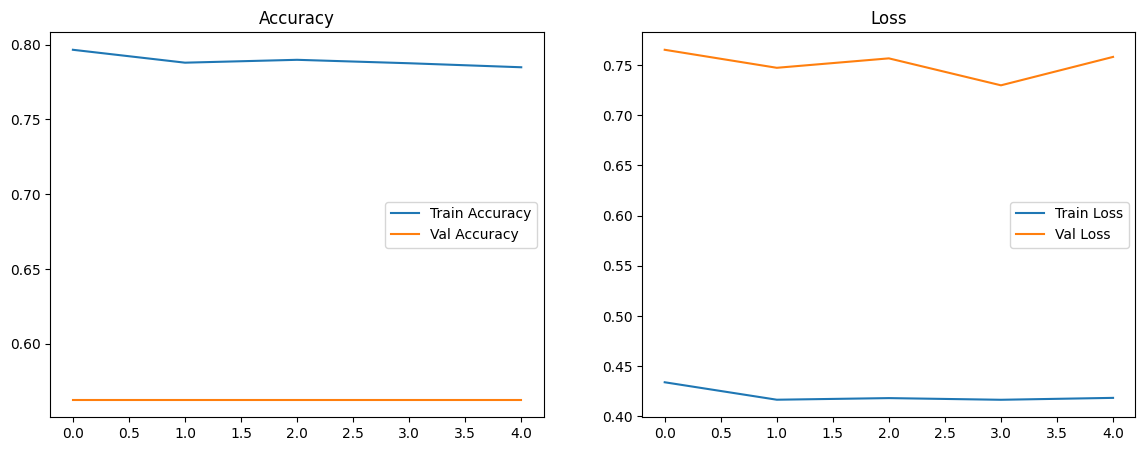

In [27]:
plot_history(history_finetune)

In [19]:
EvaluateOnTestSet()

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - accuracy: 0.4581 - loss: 0.7989

Test Accuracy: 0.71 - Loss: 0.53


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict classes
y_pred_probs = model.predict(test_generator)
y_pred = np.round(y_pred_probs).astype(int)  # binary classification

# Get true labels
y_true = test_generator.classes

# Print report
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 360ms/step
              precision    recall  f1-score   support

      NORMAL       0.77      0.32      0.45       234
   PNEUMONIA       0.70      0.94      0.80       390

    accuracy                           0.71       624
   macro avg       0.73      0.63      0.63       624
weighted avg       0.72      0.71      0.67       624



In [21]:
model.save("resnet50_pneumonia_finetuned.h5")

By now we have understood that the model is really good at detecting pneumonia (recall = 93%) but fails to catch many NORMAL cases (recall = 38%).

Tere are some possible reasons: Pneumonia samples are more than normal ones. Also, Binary cross-entropy treats both classes equally by default.

## In the next steps, since I think the normal samples are underrepresented, I will add some class weights to balance the bias.

In [22]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 1.9448173005219984, 1: 0.6730322580645162}


In [28]:
history_focal_loss = model.fit(
    train_generator_aug,
    epochs=total_epochs,
    initial_epoch=10,
    validation_data=val_generator,
    class_weight=class_weights
)

Epoch 11/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 625ms/step - accuracy: 0.8091 - loss: 0.4838 - val_accuracy: 0.6250 - val_loss: 0.5725
Epoch 12/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 621ms/step - accuracy: 0.8041 - loss: 0.4854 - val_accuracy: 0.6250 - val_loss: 0.5620
Epoch 13/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 516ms/step - accuracy: 0.8063 - loss: 0.4775 - val_accuracy: 0.6250 - val_loss: 0.5733
Epoch 14/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 514ms/step - accuracy: 0.8055 - loss: 0.4779 - val_accuracy: 0.6250 - val_loss: 0.5636
Epoch 15/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 522ms/step - accuracy: 0.8152 - loss: 0.4707 - val_accuracy: 0.6250 - val_loss: 0.5695


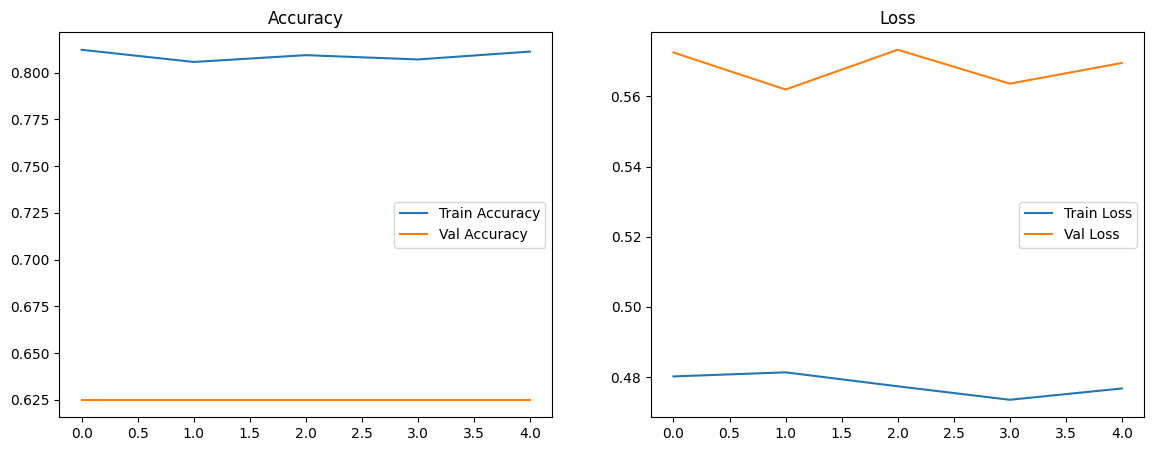

In [29]:
plot_history(history_focal_loss)

In [24]:
EvaluateOnTestSet()

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - accuracy: 0.7675 - loss: 0.5344

Test Accuracy: 0.79 - Loss: 0.52


In [25]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int)

print(classification_report(y_true, y_pred_classes, target_names=['NORMAL', 'PNEUMONIA']))


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step
              precision    recall  f1-score   support

      NORMAL       0.70      0.76      0.73       234
   PNEUMONIA       0.85      0.81      0.83       390

    accuracy                           0.79       624
   macro avg       0.78      0.79      0.78       624
weighted avg       0.80      0.79      0.79       624



In [26]:
model.save("pneumonia_detection_focal_loss.h5")

 ## Switched to Focal Loss to better handle class imbalance.
 ## Accuracy improved to 79%, with better balance between detecting NORMAL and PNEUMONIA.